In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    LinearRegression,
    SGDRegressor,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    train_test_split,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm import tqdm
from utils import DATA_ROOT, RESULTS_ROOT

ORDERED_FOLDERS_EC = [
    "20210916_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211018_FTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211019_AAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    "20211119_FTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_AAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211025_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_FTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_AAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
]

ORDERED_FOLDERS_EO = [
    "20211108_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_FTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_AAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    # "20211109_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211108_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211109_FTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211109_AAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211109_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_FTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_AAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211112_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_FTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_AAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_IAAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    # "20211110_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211120_FTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_AAFTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_IAAFTsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EO_seeded_subjectwise",
]

# plt.style.use("default_light")

## Input data - X

In [2]:
all_dfs_EC = []
for fold in tqdm(ORDERED_FOLDERS_EC):
    df = pd.read_csv(os.path.join(RESULTS_ROOT, fold, "latent_stats.csv"), index_col=0)
    all_dfs_EC.append(df)


all_dfs_EO = []
for fold in tqdm(ORDERED_FOLDERS_EO):
    df = pd.read_csv(os.path.join(RESULTS_ROOT, fold, "latent_stats.csv"), index_col=0)
    all_dfs_EO.append(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 322.97it/s]


In [3]:
names = ["microstates", "PCA", "ICA", "hmm"]
ii = [0, 5, 10, 15]

latent_data = {}

for i, name in zip(ii, names):
    df_EC = all_dfs_EC[i][
        ["subject_id", "latent map", "coverage", "occurrence", "lifespan"]
    ]
    df_EC["subject_id"] = df_EC["subject_id"].apply(lambda x: x.split("_")[0].strip())
    df_EC = df_EC.set_index(["subject_id", "latent map"]).unstack(level=1)
    df_EC.columns = ["-".join(col).strip() for col in df_EC.columns.values]
    df_EC["data_type"] = "EC"

    df_EO = all_dfs_EO[i][
        ["subject_id", "latent map", "coverage", "occurrence", "lifespan"]
    ]
    df_EO["subject_id"] = df_EO["subject_id"].apply(lambda x: x.split("_")[0].strip())
    df_EO = df_EO.set_index(["subject_id", "latent map"]).unstack(level=1)
    df_EO.columns = ["-".join(col).strip() for col in df_EO.columns.values]
    df_EO["data_type"] = "EO"

    latent_data[name] = pd.concat([df_EC, df_EO], axis=0)
    latent_data[name] = latent_data[name].pivot(columns="data_type")
    latent_data[name].columns = ["-".join(col).strip() for col in latent_data[name].columns.values]

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Output - Y

In [4]:
behavioral = {}

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "BISBAS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["CVLT"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "CERQ.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["CERQ"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "COPE.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["COPE"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "ERQ.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["ERQ"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "F-SozU_K-22.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["F-SozU_K-22"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "FEV.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["FEV"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "FTP.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["FTP"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "LOT-R.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["LOT-R"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "MARS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["MARS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "MDBF_Day1.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["MDBF_Day1"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "MSPSS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["MSPSS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "NEO_FFI.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["NEO_FFI"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "NYC_Q_lemon.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["NYC_Q_lemon"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "PSQ.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["PSQ"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "STAI_G_X2.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["STAI_G_X2"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "STAXI.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["STAXI"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "TAS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["TAS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "TEIQue-SF.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["TEIQue-SF"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "TICS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["TICS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "UPPS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["UPPS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "behavioral_LEMON", "YFAS.csv"))
df = df.rename(columns={"ID": "subject_id"})
behavioral["YFAS"] = deepcopy(df)

In [5]:
classifiers = {
    "SVR": MultiOutputRegressor(SVR()),
    "BayesRidge": MultiOutputRegressor(BayesianRidge()),
    "GradientBoostingR": MultiOutputRegressor(GradientBoostingRegressor()),
    "SGDR": MultiOutputRegressor(SGDRegressor()),
    "LightGBM": MultiOutputRegressor(LGBMRegressor()),
    "linear": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    # "KernelRidge": KernelRidge(),
}

In [6]:
results = pd.DataFrame()
pbar = tqdm(total=len(behavioral) * len(classifiers) * 2 * len(latent_data))

for lat_name, lat_df in latent_data.items():
    for beh_name, beh_df in behavioral.items():
        x_data = deepcopy(lat_df)
        beh_df = beh_df.set_index("subject_id")
        # match indices
        in_both = np.intersect1d(x_data.dropna().index, beh_df.dropna().index)
        if len(in_both) < 10:
            pbar.update(2*len(classifiers))
            continue
        x_data = x_data.loc[in_both, :]
        beh_df = beh_df.loc[in_both, :]
        x = x_data.values
        y = beh_df.values
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        y = scaler.fit_transform(y)
        for name, clf in classifiers.items():
            folds = KFold(n_splits=20, shuffle=True)
            scores = cross_val_score(clf, x, y, scoring="r2", cv=folds, n_jobs=8)
            temp = pd.DataFrame({"R2": scores})
            temp["regressor"] = name
            temp["decomposition"] = lat_name
            temp["dataset"] = beh_name
            temp["CV method"] = "KFold: 20"
            results = pd.concat([results, temp])
            pbar.update(1)

            ss = ShuffleSplit(n_splits=10, train_size=0.7)
            scores = cross_val_score(clf, x, y, scoring="r2", cv=ss, n_jobs=8)
            temp = pd.DataFrame({"R2": scores})
            temp["regressor"] = name
            temp["decomposition"] = lat_name
            temp["dataset"] = beh_name
            temp["CV method"] = "ShuffleSplit: 10 / 0.7"
            results = pd.concat([results, temp])
            pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1343/1344 [06:44<00:00,  6.93it/s]

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


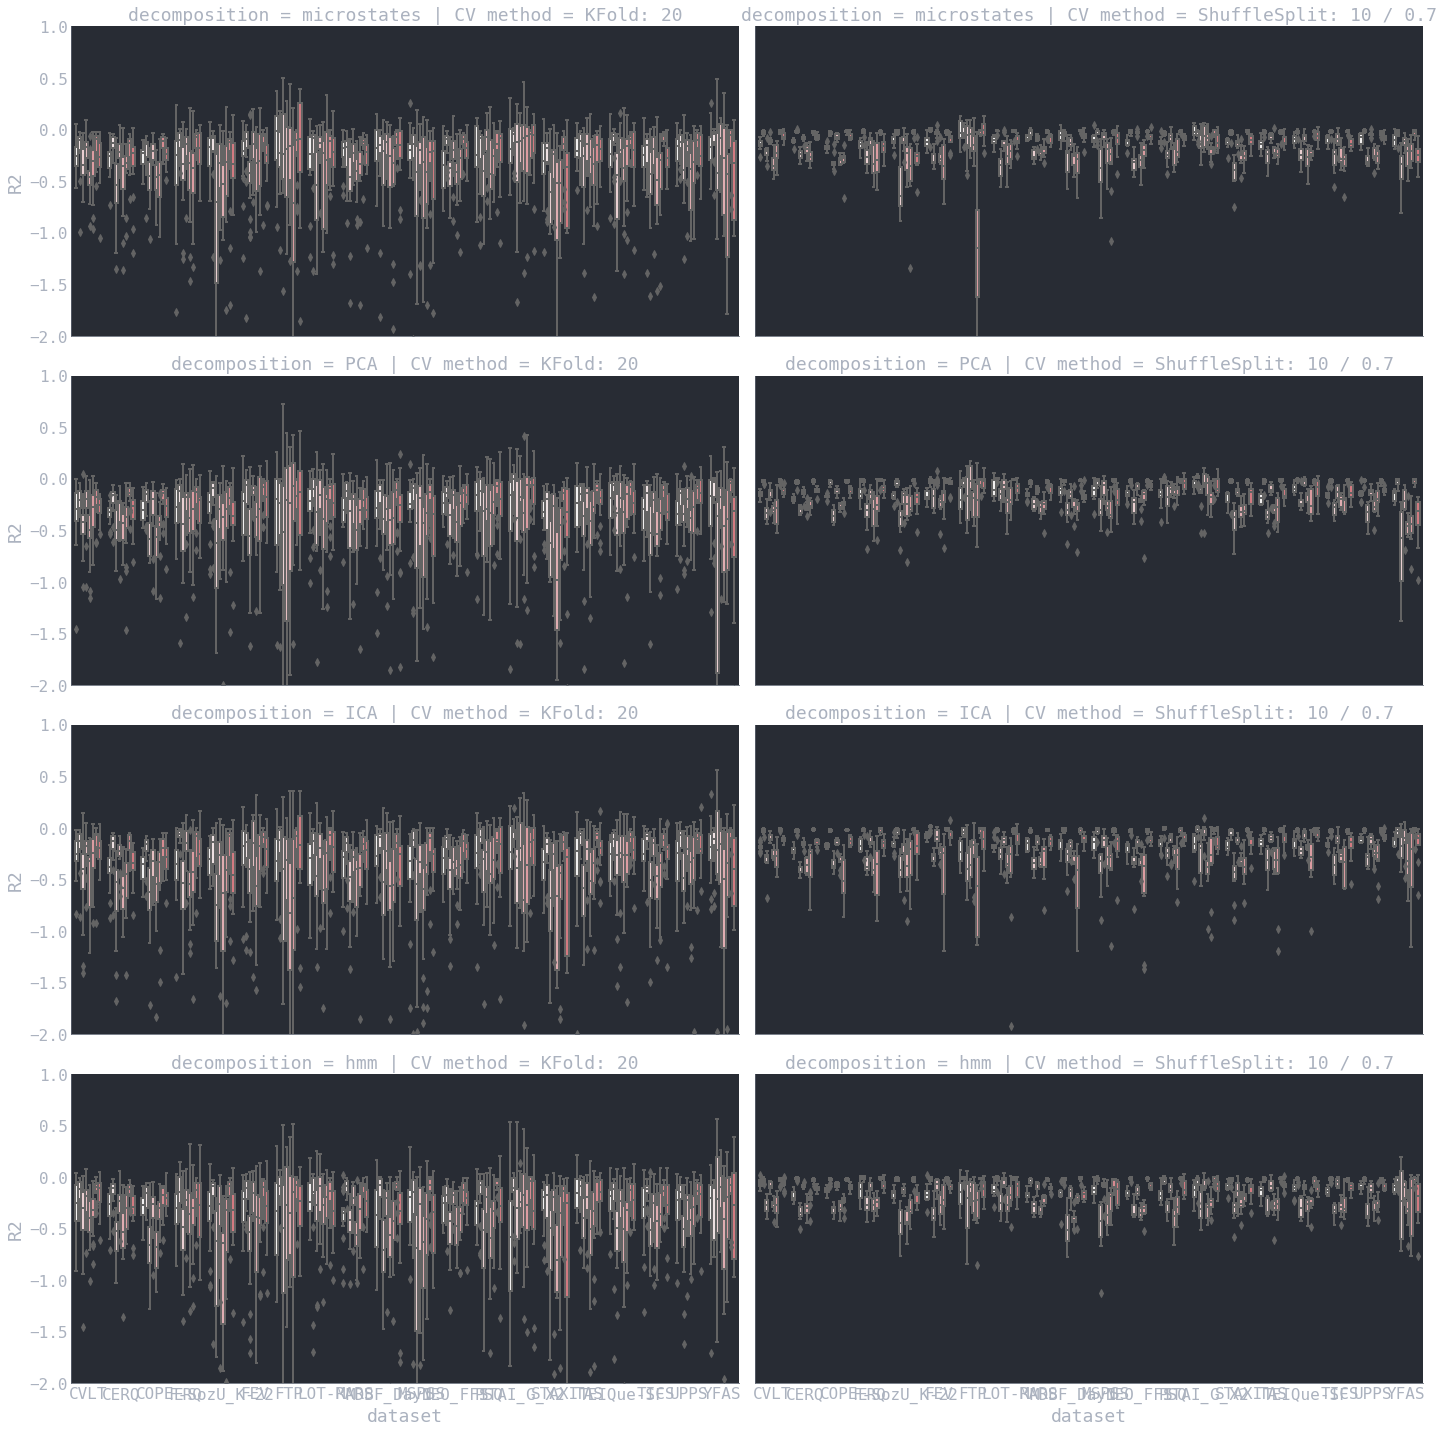

In [9]:
# results
g = sns.FacetGrid(results, col="CV method", row="decomposition", ylim=[-2, 1], size=5, aspect=2)
g.map(sns.boxplot, "dataset", "R2", "regressor")
